# Managerial X Statistical X Computational

## connect your managerial expertise to cartesian product of statisical and compuational models
![statcomp_choice](data/image/statcomp_choice.png)
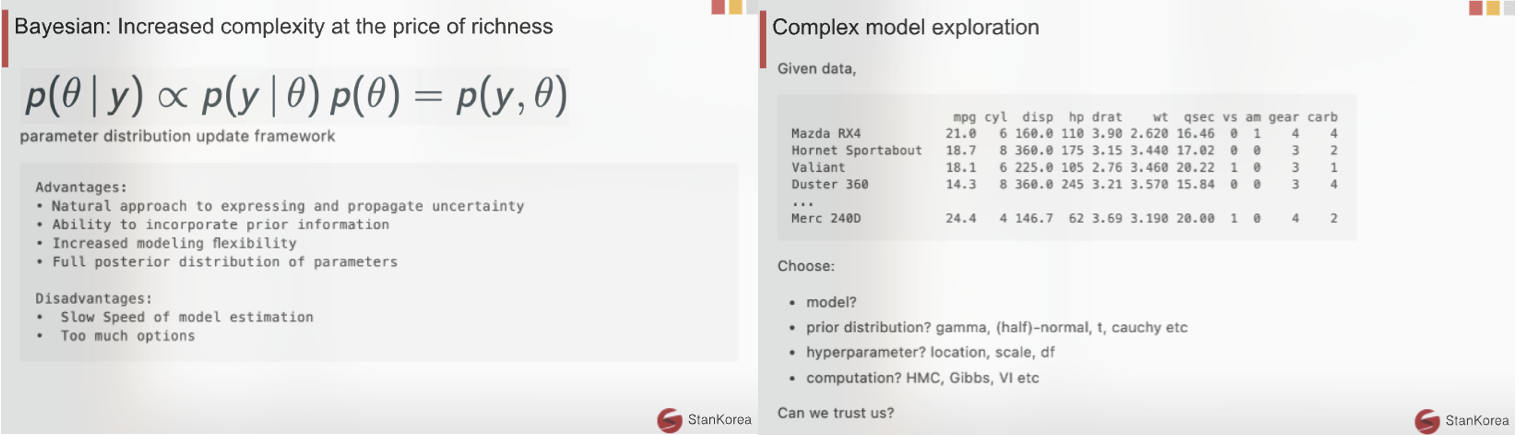

- vensim and stan is movie and novel: abstraction rate differs but both have structure and need internal consistency
	- Ali's comment on internal consistency
	- stock and flow consistency check ("seven unsustainable financial process in America")

## 1 file consistency
: `.mdl`, `.voc`, `.lst`, `chg_lst`, `.cin`, `.vdf` in one `.stan` file (`draws2data`, `data2draws`)

## $3^{+}$ language connection
: to stan's ecosystem on Python (`arviz`) , R (`ulam`, `brms`, `SBC`, `posterior`, `shinystan`), Julia 

## $\infty$ control
: modularized block coding (`data`, `parameter`, `model`, `generated quantities`)
- (if time permits) one image of final goal in automated and modular programming with birthday workflow

Map of Vensim - Stan will be logged in [here](https://github.com/Data4DM/BayesSD/discussions/61) after verified by Hazhir and Tom.

In [3]:
# !pip3 install pysd
# !pip3 install matplotlib
# !pip3 install cmdstanpy
# !pip3 install arviz

In [16]:
import matplotlib
matplotlib.use('TkAgg')
import pandas as pd
import numpy as np
import cmdstanpy
#cmdstanpy.install_cmdstan()
from pysd.translators.vensim.vensim_file import VensimFile
from stanify.calibrator.draws_data_mapper import  draws2data, data2draws
from stanify.builders.stan_model import StanVensimModel
from stanify.calibrator.visualizer import prior_pred_check, posterior_check

# generator with process noise
# equations from vensim
vf = VensimFile('vensim_models/prey_predator/prey_predator.mdl')
vf.parse()
structural_assumption = vf.get_abstract_model()

In [ ]:
# if cmdstan doesn't compile, reinstall: https://discourse.mc-stan.org/t/problems-compiling-model/25170
# !install_cmdstan
# !ls -F ~/.cmdstan

Setting and numeric assumptions

In [27]:
# data for stan blocks
setting_assumption = {
    "est_param" : ("alpha", "beta", "gamma", "delta"),
    "driving_vector_names" : ("process_noise_uniform_driving"),
    "target_simulated_vector_names" : ("prey", "predator"),
    "model_name": "prey_predator_1020",
}

n_t = 10
numeric_data_assumption = {
    "n_t":n_t,
    "time_step": .03,
    "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size=n_t),
    'process_noise_scale': 0.1
}
for key in setting_assumption['target_simulated_vector_names']:
    numeric_data_assumption[f"{key}_obs"] = [0]*n_t


Define model and prior

In [28]:
model = StanVensimModel(structural_assumption)
model.set_numeric(numeric_data_assumption)
model.set_setting(**setting_assumption)

# parameter setting for good posterior space 
model.set_prior("alpha", "normal", 0.8, 0.08, lower = 0)
model.set_prior("beta", "normal", 0.05, 0.005, lower = 0)
model.set_prior("delta", "normal", 0.05, 0.005, lower = 0)
model.set_prior("gamma", "normal", 0.8, 0.08, lower = 0)

model.set_prior("m_noise_scale", "normal", 0.5, 0.05, lower = 0)

for key in setting_assumption['target_simulated_vector_names']:
    model.set_prior(f"{key}_obs", "normal", f"{key}", "m_noise_scale")

model.build_stan_functions()

prey_predator_1020_functions.stan already exists in the current working directory. Overwrite? (y/n): y


Generate

Installing CmdStan version: 2.30.1
Install directory: /home/jovyan/.cmdstan
Download successful, file: /tmp/tmpigj1me6d
Extracting distribution
Unpacked download as cmdstan-2.30.1
Building version cmdstan-2.30.1, may take several minutes, depending on your system.
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/cmdstanpy/install_cmdstan.py", line 281, in build
    do_command(cmd, fd_out=None)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/cmdstanpy/utils/command.py", line 76, in do_command
    raise RuntimeError(msg)
RuntimeError: Command ['make', 'build', '-j1']
	error during processing No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/bin/install_cmdstan", line 8, in <module>
    sys.exit(__main__())
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/cmdstanpy/install_cmdstan.py", line 673, in __main_

In [2]:
prior_pred_obs_xr = draws2data(model, numeric_data_assumption, iter_sampling = 1) # run this only once; it compiles and stores data
prior_pred_obs = {k: v.values.flatten() for (k,v) in prior_pred_obs_xr[['prey_obs','predator_obs']].items()}
prior_pred_check(setting_assumption)

NameError: name 'draws2data' is not defined

Estimate with process noise turned off

In [ ]:
# estimator without process noise
numeric_data_assumption["process_noise_scale"] = 0.0
for key, value in prior_pred_obs.items():
    numeric_data_assumption[key] = value

Numeric value from generate step above is passed on for estimation

In [ ]:
model.update_numeric({'prey_obs': prior_pred_obs['prey_obs'], 'predator_obs': prior_pred_obs['predator_obs'],'process_noise_scale': 0.0 })
posterior = data2draws(model, numeric_data_assumption, iter_sampling = 1000)

Next week todo
i.e. questions we can answer:
1. loglikehood

I expect 1 + Beta(2,2) time to be left, which allows me to introduce modularized stan:

## Birthday workflow
new additions are qualitatively so clear improvements that there is no need for quantitative model comparison whether the additions are significant and there is no danger of overfitting

![birthday](data/image/birthday.png)

## Drawing maps of model space with modular stan

[demo](http://ryanbe.me/), [explanation](https://statmodeling.stat.columbia.edu/2021/11/19/drawing-maps-of-model-space-with-modular-stan/), [code](https://github.com/rybern/mstan)
![mstan](data/image/mstan.png)
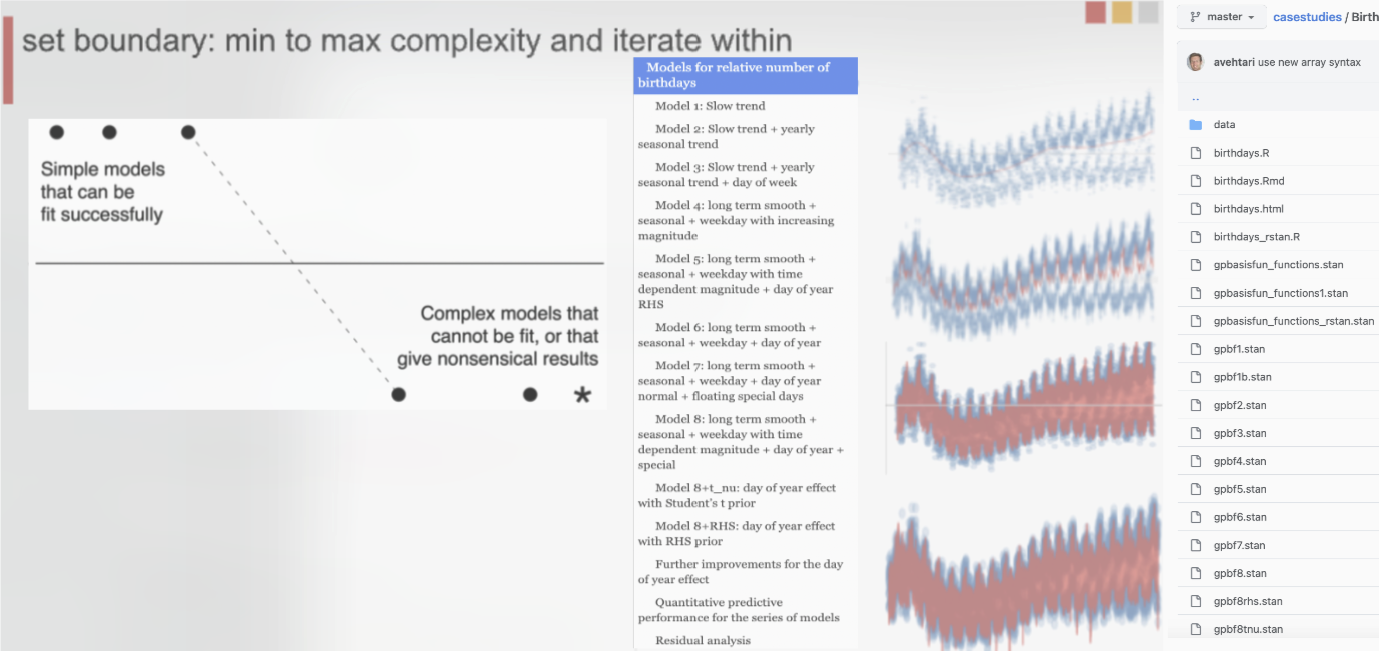
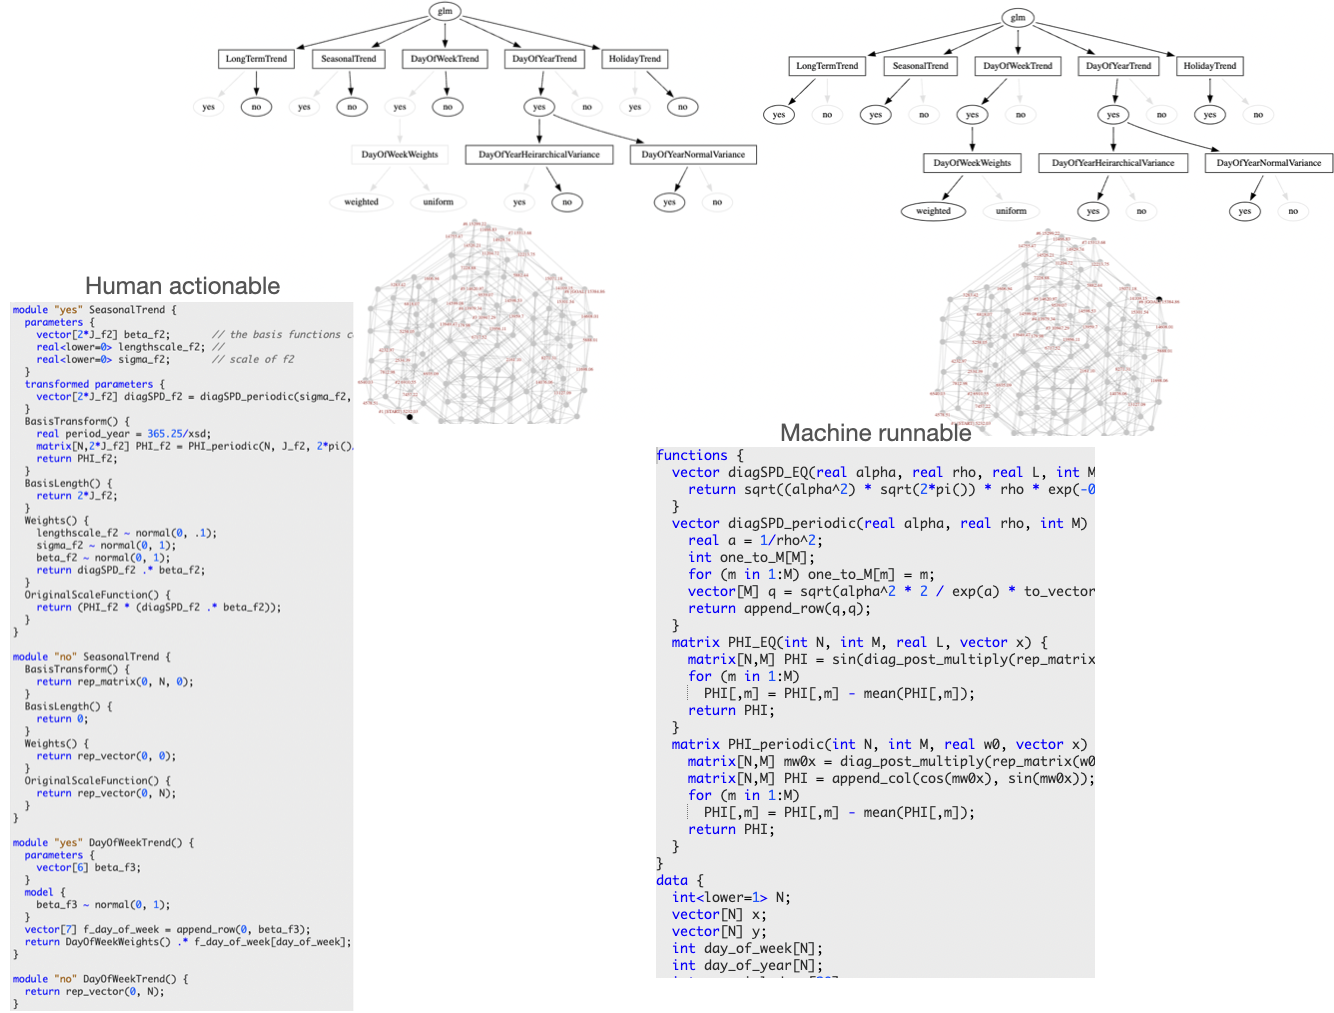